<a href="https://colab.research.google.com/github/dwiiittt/PACD_Project/blob/main/detect_tb_aliimron_v101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect TB dari Gambar CXR

## Enhancement

Pada notebook ini terdapat pipeline ESFERM untuk deteksi tbc berdasarkan unsur berikut:
- Infiltrat / konsolidasi: menggunakan `clahe` (histogram eq)
- Fibrosis: menggunakan `unsharp` dan filter Gabor untuk ekstrak fitur linear
- Kalsifikasi: menggunakan `tophat` untuk mengambil spot terang
- Kavitas: menggunakan `clahe` dan filter `median` untuk noise removal, lalu cari lubang gelap pada area high-intesity dengan `LoG` untuk bantu menegaskan rim
- Efusi: menggunakan  `gaussian blur` dengan sigma besar.

In [2]:
import numpy as np
from PIL import Image
import math
from itertools import product
from collections import deque

In [3]:
# connect dengan dataset di google drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

BASE_DIR = '/content/drive/MyDrive/datasets'

if os.path.exists(BASE_DIR):
    print(f"Folder datasets ditemukan di: {BASE_DIR}")
else:
    print(f"ERROR: Folder datasets tidak ditemukan di {BASE_DIR}. Mohon periksa kembali path.")

Folder datasets ditemukan di: /content/drive/MyDrive/datasets


In [7]:
import glob
import os

# Asumsi BASE_DIR sudah didefinisikan dengan benar
SUBFOLDERS = ['tb', 'nontb']
IMAGE_EXTENSIONS = ['jpg', 'jpeg', 'png', 'JPG', 'PNG']

all_image_paths = []

for folder_name in SUBFOLDERS:
    folder_path = os.path.join(BASE_DIR, folder_name)

    # Tambahkan semua ekstensi yang dicari di dalam subfolder ini
    for ext in IMAGE_EXTENSIONS:
        search_pattern = os.path.join(folder_path, f'*.{ext}')
        files_found = glob.glob(search_pattern)
        all_image_paths.extend(files_found)

# Hasil
print(f"\nTotal gambar yang ditemukan: {len(all_image_paths)}")
if all_image_paths:
    print(f"Contoh path gambar pertama: {all_image_paths[0]}")

# all_image_paths sekarang berisi daftar lengkap semua gambar yang dapat Anda gunakan


Total gambar yang ditemukan: 200
Contoh path gambar pertama: /content/drive/MyDrive/datasets/tb/TB.81.jpg


In [8]:
# Input gambar sebagai grayscale
def load_gray(path):
    img = Image.open(path).convert('L')
    arr = np.asarray(img).astype(np.float32)
    return arr

# Simpan gambar
def save_gray(arr, path):
    a = np.clip(arr, 0, 255).astype(np.uint8)
    Image.fromarray(a).save(path)

In [9]:
# Menghilangkan marker/artefak sangat terang atau gelap
# Nilai default: 1-99%
# Untuk gambar 256x256 digunakan p_low=1, p_high=99
def percentile_clip_and_rescale(img, p_low=1.0, p_high=99.0):
    lo = np.percentile(img, p_low)
    hi = np.percentile(img, p_high)
    if hi <= lo:
        return img.copy()
    out = (img - lo) * (255.0 / (hi - lo))
    return np.clip(out, 0, 255)

def gamma_correction(img, gamma=1.0):
    # img in 0..255
    lut = ((np.arange(256) / 255.0) ** gamma) * 255.0
    lut = lut.astype(np.float32)
    indices = np.clip(img.astype(int), 0, 255)
    return lut[indices]

In [10]:
# median filter menggunakan kernel defaul 3x3
def median_filter(img, k=3):
    assert k % 2 == 1
    pad = k // 2
    H, W = img.shape
    padded = np.pad(img, pad, mode='edge')
    out = np.empty_like(img)
    # naive version: sliding window (vectorized improvement possible)
    for i in range(H):
        for j in range(W):
            patch = padded[i:i+k, j:j+k]
            out[i, j] = np.median(patch)
    return out

In [11]:
# gaussian kernel
def gaussian_kernel_1d(sigma, radius=None):
    if radius is None:
        radius = max(1, int(math.ceil(3 * sigma)))
    x = np.arange(-radius, radius+1)
    g = np.exp(-(x**2) / (2*sigma*sigma))
    g = g / g.sum()
    return g


# konvolusi
def separable_convolve(img, kernel_1d):
    pad = len(kernel_1d)//2
    # convolve rows then cols
    H, W = img.shape
    # pad
    p = np.pad(img, ((0,0),(pad,pad)), mode='edge')
    tmp = np.empty_like(p)
    # horizontal
    for i in range(H):
        row = p[i]
        # use numpy convolution for speed on 1D
        tmp[i, pad:pad+W] = np.convolve(row, kernel_1d, mode='valid')
    # vertical pad
    tmp2 = np.pad(tmp[:, pad:pad+W], ((pad,pad),(0,0)), mode='edge')
    out = np.empty_like(tmp2)
    for j in range(W):
        col = tmp2[:, j]
        out[pad:pad+H, j] = np.convolve(col, kernel_1d, mode='valid')
    return out[pad:pad+H, :W]

# gaussian blur: untuk unsharp mask, untuk 512px pakai sigma=1
def gaussian_blur(img, sigma):
    k = gaussian_kernel_1d(sigma)
    return separable_convolve(img, k)

In [12]:
# unsharp_mask, untuk meningkatkan pola rim dan retikular (fibrosis)
def unsharp_mask(img, sigma=1.0, amount=1.0):
    blurred = gaussian_blur(img, sigma)
    mask = img - blurred
    out = img + amount * mask
    return np.clip(out, 0, 255)

In [13]:
# Laplacian of Gaussian (LoG)
def log_kernel(sigma, radius=None):
    if radius is None:
        radius = int(math.ceil(3 * sigma))
    size = 2*radius + 1
    x = np.arange(-radius, radius+1)
    xx, yy = np.meshgrid(x, x)
    r2 = xx*xx + yy*yy
    s2 = sigma*sigma
    norm = -1/(math.pi * s2*s2)
    k = norm * (1 - r2/(2*s2)) * np.exp(-r2/(2*s2))
    # normalize to zero sum
    k = k - k.mean()
    return k

def convolve2d(img, kernel):
    # simple 2D convolution (flip kernel)
    kr, kc = kernel.shape
    pad_r = kr//2
    pad_c = kc//2
    H, W = img.shape
    p = np.pad(img, ((pad_r,pad_r),(pad_c,pad_c)), mode='edge')
    out = np.empty_like(img)
    # naive loops
    for i in range(H):
        for j in range(W):
            patch = p[i:i+kr, j:j+kc]
            out[i,j] = np.sum(patch * kernel)
    return out

def log_filter(img, sigma=1.2):
    k = log_kernel(sigma)
    return convolve2d(img, k)

In [14]:
# filter Gabor -> untuk mendeteksi arah linear (fibrosis)
def gabor_kernel(lambd=8.0, theta=0.0, sigma=None, gamma=0.5, psi=0):
    if sigma is None:
        sigma = 0.56 * lambd
    radius = int(math.ceil(3 * sigma))
    x = np.arange(-radius, radius+1)
    xx, yy = np.meshgrid(x, x)
    # rotate
    x_theta =  xx * np.cos(theta) + yy * np.sin(theta)
    y_theta = -xx * np.sin(theta) + yy * np.cos(theta)
    gb = np.exp(-(x_theta**2 + (gamma**2)*(y_theta**2)) / (2*sigma*sigma))
    gb *= np.cos(2*math.pi * x_theta / lambd + psi)
    return gb

def gabor_filter(img, lambd=8.0, theta=0.0):
    k = gabor_kernel(lambd, theta)
    return convolve2d(img, k)

In [15]:
# operasi morfologi: disk_structuring_element, grayscale_erode, grayscale_dilate, opening, white_top_hat
def disk_structuring_element(radius):
    L = 2*radius + 1
    x = np.arange(-radius, radius+1)
    xx, yy = np.meshgrid(x, x)
    se = (xx*xx + yy*yy) <= (radius*radius)
    return se.astype(np.uint8)

def grayscale_erode(img, se):
    # img float, se binary
    r, c = se.shape
    pr = r//2; pc = c//2
    H, W = img.shape
    p = np.pad(img, ((pr,pr),(pc,pc)), mode='edge')
    out = np.empty_like(img)
    inds = np.argwhere(se)
    for i in range(H):
        for j in range(W):
            region = p[i:i+r, j:j+c]
            vals = region[se.astype(bool)]
            out[i,j] = vals.min()
    return out

def grayscale_dilate(img, se):
    r, c = se.shape
    pr = r//2; pc = c//2
    H, W = img.shape
    p = np.pad(img, ((pr,pr),(pc,pc)), mode='edge')
    out = np.empty_like(img)
    inds = np.argwhere(se)
    for i in range(H):
        for j in range(W):
            region = p[i:i+r, j:j+c]
            vals = region[se.astype(bool)]
            out[i,j] = vals.max()
    return out

def opening(img, se):
    return grayscale_dilate(grayscale_erode(img, se), se)

def white_top_hat(img, se):
    # top-hat = img - opening(img)
    op = opening(img, se)
    return img - op

In [16]:
# CLAHE: membagi gambar menjadi tiles, lalu melakukan hist eq di tiap tile
def clahe(img, clip_limit=2.0, tile_grid_size=(8,8), nbins=256):
    H, W = img.shape
    th, tw = tile_grid_size
    # tile sizes (last tiles may be larger to cover whole image)
    tile_h = math.ceil(H / th)
    tile_w = math.ceil(W / tw)
    out = np.zeros_like(img)
    # compute hist and CDF per tile
    # process tiles and bilinear interpolate between tile mappings
    cdfs = []
    hist_bins = np.linspace(0, 256, nbins+1)
    lut_tiles = {}
    for i in range(th):
        row_cdfs = []
        for j in range(tw):
            y0 = i*tile_h
            x0 = j*tile_w
            y1 = min((i+1)*tile_h, H)
            x1 = min((j+1)*tile_w, W)
            tile = img[y0:y1, x0:x1].astype(np.uint8)
            hist, _ = np.histogram(tile.flatten(), bins=hist_bins)
            # clip histogram
            max_clip = clip_limit * tile.size / nbins
            excess = hist - max_clip
            excess[excess < 0] = 0
            total_excess = int(excess.sum())
            hist = np.minimum(hist, max_clip)
            # redistribute excess uniformly
            if total_excess > 0:
                hist += (total_excess // nbins)
            cdf = np.cumsum(hist).astype(np.float64)
            if cdf[-1] == 0:
                cdf = cdf
            else:
                cdf = (cdf - cdf.min()) / (cdf[-1] - cdf.min()) * 255.0
            row_cdfs.append(cdf)
        cdfs.append(row_cdfs)
    # bilinear interpolation per pixel
    for y in range(H):
        ty = (y + 0.5) / tile_h - 0.5
        i = int(math.floor(max(0, min(th-1, ty))))
        dy = ty - i
        for x in range(W):
            tx = (x + 0.5) / tile_w - 0.5
            j = int(math.floor(max(0, min(tw-1, tx))))
            dx = tx - j
            # clamp indices for interpolation neighbors
            i1 = min(i+1, th-1)
            j1 = min(j+1, tw-1)
            # get cdfs for 4 neighbors
            c00 = cdfs[i][j]
            c10 = cdfs[i1][j]
            c01 = cdfs[i][j1]
            c11 = cdfs[i1][j1]
            val = img[y,x].astype(int)
            # bilinear weights
            w00 = (1-dy)*(1-dx)
            w10 = dy*(1-dx)
            w01 = (1-dy)*dx
            w11 = dy*dx
            mapped = w00*c00[val] + w10*c10[val] + w01*c01[val] + w11*c11[val]
            out[y,x] = mapped
    return np.clip(out, 0, 255)

In [17]:
# memastikan skala gambar
def scale_param_for_resolution(base_value, base_res=512, current_res=None):
    if current_res is None:
        return base_value
    factor = current_res / base_res
    return max(1, int(round(base_value * factor)))

In [18]:
# ESFERM
def esferm_pipeline(img_arr, res_reference=512):
    H, W = img_arr.shape
    res_scale = (H + W)/2.0
    # 1) percentile clip & rescale
    a = percentile_clip_and_rescale(img_arr, p_low=1.0, p_high=99.0)
    # 2) denoise (median)
    med_k = 3 if res_scale <= 512 else 5
    b = median_filter(a, k=med_k)
    # 3) CLAHE
    tile = (max(2, int(8 * (res_scale/512))),) * 2
    c = clahe(b, clip_limit=2.0, tile_grid_size=tile)
    # 4) unsharp
    sigma = 1.0 * (res_scale/512)
    d = unsharp_mask(c, sigma=sigma, amount=1.0)
    # 5) top-hat for bright spots
    rad = scale_param_for_resolution(3, base_res=512, current_res=res_scale)
    se = disk_structuring_element(rad)
    e = white_top_hat(c, se)  # apply on CLAHE result
    # 6) LoG (for edges)
    log = log_filter(c, sigma=1.2*(res_scale/512))
    return {
        'clipped': a, 'median': b, 'clahe': c, 'unsharp': d, 'tophat': e, 'log': log
    }

In [20]:
import sys

# testing
path = "/content/drive/MyDrive/datasets/esfermtest/TB.6.jpg"
img = load_gray(path)
outs = esferm_pipeline(img)
for k, v in outs.items():
    save_gray(v, f"out_{k}.png")
print("Saved outputs:", ", ".join(f"out_{k}.png" for k in outs.keys()))

Saved outputs: out_clipped.png, out_median.png, out_clahe.png, out_unsharp.png, out_tophat.png, out_log.png


## Segmentasi Paru (Region of Interest)

Metode yang dipakai
1. Prepocessing menggunakan hasil enhancement (`clahe`/`unsharp`) lalu thresholding adaptif untuk memisahkan paru dari jaringan tulang/jantung
2. Thresholding dengan Otsu method, lalu pilih region gelap
3. Morphological Cleanup dengan menghilangan objek kecil seperti marker atau noise, lalu closing (`dilate` lalu `erode`) untuk menutup gap di tepi paru, serta opening untuk menghapus objek kecil yang bukan paru
4. Connected Components, yaitu memilih 2 komponen terbesar di kedua sisi, yaitu paru-pary=u.

**Segmentasi Lesi khusus TB**

- Infiltrat & Konsolidasi
→ Area abu-abu homogen (opacity meningkat).
→ Bisa didapat dengan threshold intensity di dalam paru + region-growing.

- Kavitas
→ Bentuk bulat/oval, relatif gelap, dikelilingi oleh area opacity.
→ Bisa pakai edge detection (LoG) + cari hole-like region.

- Efusi Pleura
→ Area opacity homogen di dasar paru (menutupi sudut kostofrenikus).
→ Bisa didapat dengan threshold + lokasi (ROI bawah paru).

- Fibrosis
→ Garis-garis halus/linear.
→ Bisa dipakai Gabor filter (dari enhancement) untuk menonjolkan pola oriented, lalu threshold magnitude.

- Kalsifikasi
→ Titik putih terang kecil.
→ Gunakan hasil white top-hat → threshold → deteksi blob kecil.

**Metode yang bisa dipakai**

1. Global Thresholding
    - Otsu: hitung ambang otomatis → segmentasi background vs foreground.
    - Berguna untuk paru mask awal.

2.  Adaptive / Local Thresholding
    - Bagi gambar jadi blok (mis. 16×16), hitung threshold per blok.
    - Berguna untuk mendeteksi lesi dengan pencahayaan tidak seragam.

3. Region Growing
   - Pilih seed di area paru (mis. dari threshold).
   - Tambahkan piksel tetangga jika intensitas mirip.
   - Cocok untuk lesi homogen (infiltrat, efusi).

4. Morphological Ops
   - Opening/closing untuk memperhalus segmen.
   - Top-hat untuk nodul/kalsifikasi.
   - Hole-filling untuk cavity.

5. Edge-based (LoG / Sobel)
   - Deteksi boundary lesi → lalu region-fill.
   - Cocok untuk kavitas.

In [21]:
# load library
import numpy as np
from PIL import Image

def load_gray(path):
    img = Image.open(path).convert('L')
    return np.asarray(img, dtype=np.float32)

def show_img(img, cmap="gray"):
    import matplotlib.pyplot as plt
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    plt.show()

In [22]:
# Otsu
def otsu_threshold(img):
    hist, bins = np.histogram(img.flatten(), bins=256, range=(0, 256))
    total = img.size
    sum_total = np.dot(np.arange(256), hist)

    sumB, wB, wF, varMax, threshold = 0.0, 0, 0, 0.0, 0

    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += t * hist[t]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        varBetween = wB * wF * (mB - mF) ** 2
        if varBetween > varMax:
            varMax = varBetween
            threshold = t
    return threshold

def apply_threshold(img, th):
    return (img < th).astype(np.uint8)  # paru lebih gelap

In [23]:
# morfologi
def erode(img, se_radius=3):
    H, W = img.shape
    pad = se_radius
    out = np.zeros_like(img)
    padded = np.pad(img, pad, mode="constant", constant_values=0)
    for i in range(H):
        for j in range(W):
            region = padded[i:i+2*pad+1, j:j+2*pad+1]
            out[i,j] = 1 if np.all(region == 1) else 0
    return out

def dilate(img, se_radius=3):
    H, W = img.shape
    pad = se_radius
    out = np.zeros_like(img)
    padded = np.pad(img, pad, mode="constant", constant_values=0)
    for i in range(H):
        for j in range(W):
            region = padded[i:i+2*pad+1, j:j+2*pad+1]
            out[i,j] = 1 if np.any(region == 1) else 0
    return out

def closing(img, se_radius=3):
    return erode(dilate(img, se_radius), se_radius)

def opening(img, se_radius=3):
    return dilate(erode(img, se_radius), se_radius)

In [24]:
# Connected component
def connected_components(bin_img):
    H, W = bin_img.shape
    labels = np.zeros((H,W), dtype=np.int32)
    current_label = 0
    equivalences = {}

    def neighbors(y, x):
        for dy, dx in [(-1,0),(0,-1),(-1,-1),(-1,1)]:
            ny, nx = y+dy, x+dx
            if 0 <= ny < H and 0 <= nx < W:
                yield ny, nx

    for y in range(H):
        for x in range(W):
            if bin_img[y,x] == 0:
                continue
            neigh_labels = [labels[ny,nx] for ny,nx in neighbors(y,x) if labels[ny,nx] > 0]
            if not neigh_labels:
                current_label += 1
                labels[y,x] = current_label
                equivalences[current_label] = {current_label}
            else:
                min_label = min(neigh_labels)
                labels[y,x] = min_label
                for l in neigh_labels:
                    equivalences[min_label].update(equivalences[l])
                    equivalences[l] = equivalences[min_label]

    label_map = {}
    new_label = 1
    for y in range(H):
        for x in range(W):
            l = labels[y,x]
            if l > 0:
                root = min(equivalences[l])
                if root not in label_map:
                    label_map[root] = new_label
                    new_label += 1
                labels[y,x] = label_map[root]
    return labels, new_label-1


In [25]:
# Pipeline segmentasi paru
def segment_lung(img):
    th = otsu_threshold(img)
    mask = apply_threshold(img, th)

    # Morphology cleanup
    mask = closing(mask, se_radius=5)
    mask = opening(mask, se_radius=3)

    # Connected components → ambil 2 terbesar
    labels, n = connected_components(mask)
    areas = [(i, np.sum(labels==i)) for i in range(1, n+1)]
    areas.sort(key=lambda x: x[1], reverse=True)
    lung_mask = np.isin(labels, [areas[0][0], areas[1][0]]).astype(np.uint8)

    return lung_mask


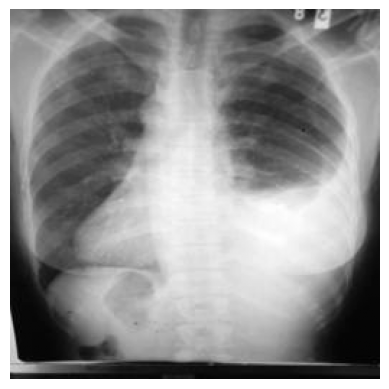

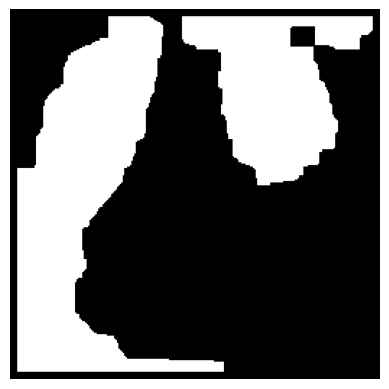

In [26]:
# test segmentasi
img = load_gray(path)

show_img(img)

lung_mask = segment_lung(img)
show_img(lung_mask, cmap="gray")

In [27]:
# overlay atau gabung dengan paru asli
def overlay_mask(img, mask, alpha=0.4):
    import matplotlib.pyplot as plt

    # Normalisasi ke [0,1]
    img_norm = (img - img.min()) / (img.max() - img.min())
    img_rgb = np.stack([img_norm]*3, axis=-1)  # grayscale → RGB

    # Buat warna overlay (merah)
    overlay = np.zeros_like(img_rgb)
    overlay[...,0] = mask  # channel R

    # Gabungkan dengan alpha blending
    blended = (1-alpha)*img_rgb + alpha*overlay

    plt.imshow(blended)
    plt.axis("off")
    plt.show()

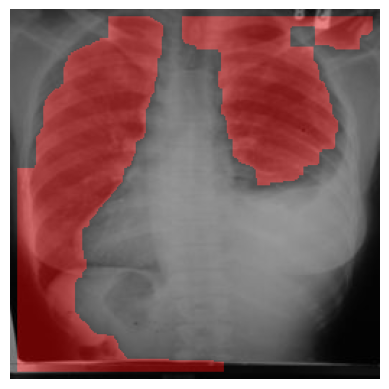

In [28]:
overlay_mask(img, lung_mask)

## Feature Extraction

**Jenis Fitur yang Relevan untuk TB**

Untuk kasus ini, fitur yang cocok biasanya:

- Intensity-based features
    - Mean intensity paru → untuk mendeteksi opacity (infiltrat, konsolidasi).
    - Histogram of intensity → distribusi gelap-terang.
    - Skewness / kurtosis dari histogram.

- Texture features
    Karena TB sering terlihat sebagai pola tekstur abnormal (opacity patchy, garis fibrosis, nodul kecil):
    - GLCM (Gray Level Co-occurrence Matrix); fitur: contrast, correlation, energy, homogeneity.
    - LBP (Local Binary Pattern); pola lokal terang-gelap.
    - Entropy; mengukur randomness.

- Shape features (untuk lesi tertentu)
    - Cavity: area melingkar, ada “hole”. Bisa hitung circularity = 4πA / P².
    - Efusi pleura: area opacity di bawah, cek proporsi area opacity di bagian bawah paru.
    - Fibrosis: pola garis, menggunakan Gabor filter response.
    - Kalsifikasi: bright spot kecil, dengan menghitung jumlah blob kecil putih.

**Pipeline**

Setelah dapat mask paru, dilakukan langkah berikut:
1. Crop ROI paru (gunakan lung_mask untuk masking).
2. Hitung fitur:
    - Intensity features dari ROI.
    - Texture features dengan GLCM / LBP.
    - Shape / location features untuk lesi.
3. Satukan jadi feature vector per gambar.

In [29]:
import numpy as np

# ===============================
# 1. GLCM MANUAL
# ===============================
def compute_glcm(img, d=1, angle=0, levels=8):
    """
    Hitung GLCM untuk 1 arah & jarak tertentu.
    angle: 0 (horizontal), 90, 45, 135.
    """
    H, W = img.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # arah
    if angle == 0:      # kanan
        dx, dy = d, 0
    elif angle == 90:   # bawah
        dx, dy = 0, d
    elif angle == 45:   # kanan atas
        dx, dy = d, -d
    elif angle == 135:  # kiri bawah
        dx, dy = -d, d
    else:
        raise ValueError("Angle harus 0, 45, 90, atau 135")

    for y in range(H):
        for x in range(W):
            nx, ny = x+dx, y+dy
            if 0 <= nx < W and 0 <= ny < H:
                i = img[y, x]
                j = img[ny, nx]
                glcm[i, j] += 1

    # normalisasi ke probabilitas
    if glcm.sum() > 0:
        glcm /= glcm.sum()
    return glcm


def glcm_features(glcm):
    """Hitung contrast, energy, homogeneity, entropy dari 1 GLCM"""
    contrast = 0
    energy = np.sum(glcm**2)
    homogeneity = 0
    entropy = 0

    levels = glcm.shape[0]
    for i in range(levels):
        for j in range(levels):
            contrast += (i-j)**2 * glcm[i,j]
            homogeneity += glcm[i,j] / (1 + abs(i-j))
            if glcm[i,j] > 0:
                entropy -= glcm[i,j] * np.log2(glcm[i,j])

    return [contrast, energy, homogeneity, entropy]


def compute_glcm_multi(img, levels=8):
    """Hitung GLCM fitur rata-rata dari 4 arah"""
    angles = [0, 45, 90, 135]
    feats = []
    for a in angles:
        glcm = compute_glcm(img, d=1, angle=a, levels=levels)
        feats.append(glcm_features(glcm))
    return np.mean(feats, axis=0)   # rata-rata semua arah


# ===============================
# 2. LBP MANUAL
# ===============================
def compute_lbp(img, P=8, R=1):
    H, W = img.shape
    lbp = np.zeros_like(img, dtype=np.uint8)

    for y in range(R, H-R):
        for x in range(R, W-R):
            center = img[y, x]
            code = 0
            for p in range(P):
                theta = 2*np.pi*p / P
                xp = int(x + R*np.cos(theta))
                yp = int(y - R*np.sin(theta))
                code <<= 1
                if img[yp, xp] >= center:
                    code |= 1
            lbp[y, x] = code
    return lbp


def lbp_features(lbp, bins=16):
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0,256), density=True)
    return hist.tolist()


# ===============================
# 3. INTENSITY FEATURES
# ===============================
def intensity_features(img):
    return [np.mean(img), np.std(img)]


# ===============================
# 4. FULL FEATURE EXTRACTOR
# ===============================
def extract_features(img, mask=None, levels=8):
    """
    Ekstrak fitur GLCM + LBP + Intensity.
    img: sudah grayscale [0..255]
    mask: binary mask (1=paru, 0=luar), optional
    """
    # apply mask kalau ada
    if mask is not None:
        img = img * mask

    # normalisasi ke [0, levels-1]
    img_q = np.floor(img / (256/levels)).astype(np.uint8)

    # GLCM
    glcm_feat = compute_glcm_multi(img_q, levels=levels)

    # LBP
    lbp_img = compute_lbp(img_q)
    lbp_feat = lbp_features(lbp_img)

    # Intensity
    int_feat = intensity_features(img_q)

    # Gabungan semua
    return np.array(glcm_feat + lbp_feat + int_feat)


In [30]:
def extract_features(img, lung_mask):
    """
    Ekstraksi fitur dari ROI paru:
    - Intensity (mean, std, entropy)
    - GLCM (contrast, energy, homogeneity, correlation)
    - LBP histogram
    """
    import math

    # Masking paru
    roi = img * lung_mask
    roi_vals = roi[lung_mask > 0]

    # === Intensity features ===
    mean_int = np.mean(roi_vals)
    std_int = np.std(roi_vals)
    hist, _ = np.histogram(roi_vals, bins=256, range=(0,256))
    p_hist = hist / (hist.sum() + 1e-6)
    entropy = -np.sum(p_hist * np.log2(p_hist + 1e-6))

    # === GLCM features ===
    glcm = compute_glcm(roi, distances=[1], angles=[0])  # dari kode GLCM sebelumnya
    contrast = compute_glcm_feature(glcm, "contrast")
    energy   = compute_glcm_feature(glcm, "energy")
    homogeneity = compute_glcm_feature(glcm, "homogeneity")
    correlation = compute_glcm_feature(glcm, "correlation")

    # === LBP features ===
    lbp_img = lbp_basic(roi)
    lbp_feat = lbp_hist(lbp_img, bins=256)  # panjang 256

    # === Gabungan ===
    features = np.hstack([
        [mean_int, std_int, entropy, contrast, energy, homogeneity, correlation],
        lbp_feat
    ])

    return features


In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray

def build_feature_dataset(tb_dir, normal_dir, max_tb=None, max_normal=None):
    """
    Ekstrak fitur dari semua gambar CXR TB & Normal.
    Args:
        tb_dir      : folder berisi gambar TB
        normal_dir  : folder berisi gambar Normal
        max_tb      : (opsional) batasi jumlah TB untuk debug
        max_normal  : (opsional) batasi jumlah Normal untuk debug
    Returns:
        X (numpy array) : matrix fitur [n_samples x n_features]
        y (numpy array) : label (1=TB, 0=Normal)
    """
    X, y = [], []

    # --- TB Images ---
    tb_files = os.listdir(tb_dir)
    if max_tb: tb_files = tb_files[:max_tb]
    for f in tb_files:
        path = os.path.join(tb_dir, f)
        try:
            img = imread(path)
            if img.ndim == 3:  # jika RGB, ubah grayscale
                img = rgb2gray(img)
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            lung_mask = segment_lung(img)  # fungsi segmentasi awal
            feats = extract_features(img, lung_mask)

            X.append(feats)
            y.append(1)  # label TB
        except Exception as e:
            print("Error TB:", f, e)

    # --- Normal Images ---
    normal_files = os.listdir(normal_dir)
    if max_normal: normal_files = normal_files[:max_normal]
    for f in normal_files:
        path = os.path.join(normal_dir, f)
        try:
            img = imread(path)
            if img.ndim == 3:
                img = rgb2gray(img)
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            lung_mask = segment_lung(img)
            feats = extract_features(img, lung_mask)

            X.append(feats)
            y.append(0)  # label Normal
        except Exception as e:
            print("Error Normal:", f, e)

    X = np.array(X)
    y = np.array(y)
    return X, y


In [ ]:
# Menjalankan ekstraksi
tb_dir = "dataset/tb"
normal_dir = "dataset/nontb"

X, y = build_feature_dataset(tb_dir, normal_dir, max_tb=50, max_normal=50)

print("Shape fitur:", X.shape)  # (jumlah_gambar, jumlah_fitur)
print("Shape label:", y.shape)
print("Contoh label distribusi:", np.bincount(y))


Error TB: TB.575.jpg operands could not be broadcast together with shapes (4,) (16,) 
Error TB: TB.576.jpg operands could not be broadcast together with shapes (4,) (16,) 
Error TB: TB.577.jpg operands could not be broadcast together with shapes (4,) (16,) 


KeyboardInterrupt: 

**Coba Darurat**

In [ ]:
import numpy as np

def segment_lung(img):
    """
    Segmentasi sederhana paru (thresholding).
    Output: mask biner (0=background, 1=paru).
    """
    # threshold otomatis pakai persentil
    thresh = np.percentile(img, 70)
    mask = (img < thresh).astype(np.uint8)
    return mask


In [ ]:
# ===== GLCM =====
def compute_glcm(img, d=1, angle=0, levels=8):
    H, W = img.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    if angle == 0: dx, dy = d, 0
    elif angle == 90: dx, dy = 0, d
    elif angle == 45: dx, dy = d, -d
    elif angle == 135: dx, dy = -d, d
    else: raise ValueError("Angle harus 0, 45, 90, atau 135")

    for y in range(H):
        for x in range(W):
            nx, ny = x+dx, y+dy
            if 0 <= nx < W and 0 <= ny < H:
                i, j = img[y, x], img[ny, nx]
                glcm[i, j] += 1

    if glcm.sum() > 0:
        glcm /= glcm.sum()
    return glcm

def glcm_features(glcm):
    contrast, energy, homogeneity, entropy = 0, 0, 0, 0
    levels = glcm.shape[0]
    for i in range(levels):
        for j in range(levels):
            contrast += (i-j)**2 * glcm[i,j]
            energy += glcm[i,j]**2
            homogeneity += glcm[i,j] / (1 + abs(i-j))
            if glcm[i,j] > 0:
                entropy -= glcm[i,j] * np.log2(glcm[i,j])
    return [contrast, energy, homogeneity, entropy]

def compute_glcm_multi(img, levels=8):
    angles = [0, 45, 90, 135]
    feats = []
    for a in angles:
        g = compute_glcm(img, d=1, angle=a, levels=levels)
        feats.append(glcm_features(g))
    return np.mean(feats, axis=0).tolist()


# ===== LBP =====
def compute_lbp(img, P=8, R=1):
    H, W = img.shape
    lbp = np.zeros_like(img, dtype=np.uint8)
    for y in range(R, H-R):
        for x in range(R, W-R):
            center = img[y, x]
            code = 0
            for p in range(P):
                theta = 2*np.pi*p / P
                xp, yp = int(x + R*np.cos(theta)), int(y - R*np.sin(theta))
                code <<= 1
                if img[yp, xp] >= center:
                    code |= 1
            lbp[y, x] = code
    return lbp

def lbp_features(lbp, bins=16):
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0,256), density=True)
    return hist.tolist()


# ===== Intensity =====
def intensity_features(img):
    return [float(np.mean(img)), float(np.std(img))]


# ===== Extractor utama =====
def extract_features(img, mask=None, levels=8):
    if mask is not None:
        img = img * mask

    img_q = np.floor(img / (256/levels)).astype(np.uint8)

    glcm_feat = compute_glcm_multi(img_q, levels=levels)
    lbp_img = compute_lbp(img_q)
    lbp_feat = lbp_features(lbp_img, bins=16)
    int_feat = intensity_features(img_q)

    return np.array(glcm_feat + lbp_feat + int_feat)


In [ ]:
import os
from skimage.io import imread
from skimage.color import rgb2gray

def build_feature_dataset(tb_dir, normal_dir, max_tb=None, max_normal=None):
    X, y = [], []

    # TB
    tb_files = os.listdir(tb_dir)
    if max_tb: tb_files = tb_files[:max_tb]
    for f in tb_files:
        path = os.path.join(tb_dir, f)
        try:
            img = imread(path)
            if img.ndim == 3:
                img = rgb2gray(img)
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            mask = segment_lung(img)
            feats = extract_features(img, mask)
            X.append(feats)
            y.append(1)
        except Exception as e:
            print("Error TB:", f, e)

    # Normal
    normal_files = os.listdir(normal_dir)
    if max_normal: normal_files = normal_files[:max_normal]
    for f in normal_files:
        path = os.path.join(normal_dir, f)
        try:
            img = imread(path)
            if img.ndim == 3:
                img = rgb2gray(img)
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            mask = segment_lung(img)
            feats = extract_features(img, mask)
            X.append(feats)
            y.append(0)
        except Exception as e:
            print("Error Normal:", f, e)

    return np.array(X), np.array(y)


In [ ]:
tb_dir = "dataset/tb"
normal_dir = "dataset/nontb"

X, y = build_feature_dataset(tb_dir, normal_dir, max_tb=20, max_normal=20)

print("Shape fitur:", X.shape)
print("Shape label:", y.shape)
print("Contoh fitur pertama:", X[0][:10])


Shape fitur: (40, 22)
Shape label: (40,)
Contoh fitur pertama: [2.84786771e-01 2.95252778e-01 9.44071331e-01 2.29873398e+00
 1.35898590e-03 4.08172607e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


**Representasi Fitur**

Hasil akhir adalah matrix fitur dengan satu CXR per baris, dan kolom berupa fitur numerik.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling fitur (biar SVM/NaiveBayes lebih stabil)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# SVM dengan kernel RBF
svm_clf = SVC(kernel="rbf", C=1, gamma="scale")
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("=== Hasil SVM ===")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=3))


=== Hasil SVM ===
[[3 1]
 [0 4]]
              precision    recall  f1-score   support

           0      1.000     0.750     0.857         4
           1      0.800     1.000     0.889         4

    accuracy                          0.875         8
   macro avg      0.900     0.875     0.873         8
weighted avg      0.900     0.875     0.873         8



In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)

print("=== Hasil Naive Bayes ===")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, digits=3))


=== Hasil Naive Bayes ===
[[4 0]
 [0 4]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         4
           1      1.000     1.000     1.000         4

    accuracy                          1.000         8
   macro avg      1.000     1.000     1.000         8
weighted avg      1.000     1.000     1.000         8



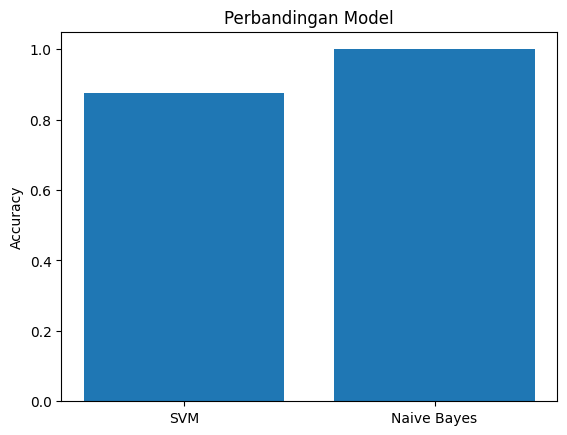

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

acc_svm = accuracy_score(y_test, y_pred_svm)
acc_nb = accuracy_score(y_test, y_pred_nb)

plt.bar(["SVM", "Naive Bayes"], [acc_svm, acc_nb])
plt.ylabel("Accuracy")
plt.title("Perbandingan Model")
plt.show()


**Testing**

In [ ]:
# testing
test_img_path = "img/TB.1536.jpg"
img = imread(test_img_path)

# Pastikan grayscale
if img.ndim == 3:
    img = rgb2gray(img)
    img = (img * 255).astype(np.uint8)
else:
    img = img.astype(np.uint8)

# Segmentasi paru
lung_mask = segment_lung(img)

# Ekstrak fitur
feats = extract_features(img, lung_mask)

# Ubah ke bentuk (1, -1) biar bisa dipakai di sklearn
feats_scaled = scaler.transform([feats])

# Prediksi dengan model
pred = svm_clf.predict(feats_scaled)[0]

print("Hasil prediksi:", "TB" if pred == 1 else "Normal")

Hasil prediksi: TB


In [ ]:
def classify_lesion(r, img):
    """Klasifikasi sederhana region (r) ke jenis lesi"""
    area = r.area
    ecc = r.eccentricity
    mean_intensity = r.mean_intensity
    cy = r.centroid[0]
    H, W = img.shape

    # --- Rule-based heuristic ---
    if r.euler_number < 1:  # ada hole
        return "Kavitas", (255, 255, 0)   # kuning
    elif cy > 2*H/3 and area > 1000:
        return "Efusi", (0, 255, 255)     # cyan
    elif area > 2000 and ecc < 0.7:
        return "Konsolidasi", (255, 0, 0) # merah
    elif area > 500 and ecc >= 0.7:
        return "Infiltrat", (0, 0, 255)   # biru
    elif area < 300 and mean_intensity > 150:
        return "Kalsifikasi", (0, 255, 0) # hijau
    elif area < 800 and ecc > 0.9:
        return "Fibrosis", (255, 0, 255)  # ungu
    else:
        return "Lesi_Lain", (128, 128, 128)  # abu-abu


# Peta warna sesuai klasifikasi
lesion_colors = {
    "Konsolidasi": (255, 0, 0),   # merah
    "Infiltrat": (0, 0, 255),     # biru
    "Kavitas": (255, 255, 0),     # kuning
    "Efusi": (0, 255, 255),       # cyan
    "Fibrosis": (255, 0, 255),    # ungu
    "Kalsifikasi": (0, 255, 0),   # hijau
    "Lesi_Lain": (128, 128, 128)  # abu-abu
}


def highlight_lesions_detailed(img, lung_mask, verbose=True):
    lung_area = img * lung_mask
    total_lung_area = lung_mask.sum()

    # Thresholding
    t = threshold_otsu(lung_area[lung_area > 0])
    lesion_mask = (lung_area > t).astype(np.uint8)

    lesion_mask = closing(lesion_mask, disk(3))
    lesion_mask = opening(lesion_mask, disk(2))
    lesion_mask = remove_small_objects(lesion_mask.astype(bool), 80).astype(np.uint8)

    labels = label(lesion_mask)
    props = regionprops(labels, intensity_image=img)

    overlay = np.zeros((*img.shape, 3), dtype=np.uint8)
    lesion_summary = {}

    for r in props:
        cls, color = classify_lesion(r, img)
        overlay[labels == r.label] = color
        lesion_summary[cls] = lesion_summary.get(cls, 0) + r.area

        if verbose:
            print(f"Region {r.label}: {cls}, area={r.area}, ecc={r.eccentricity:.2f}")

    lesion_percent = {cls: (area / total_lung_area) * 100 for cls, area in lesion_summary.items()}
    return overlay, lesion_percent


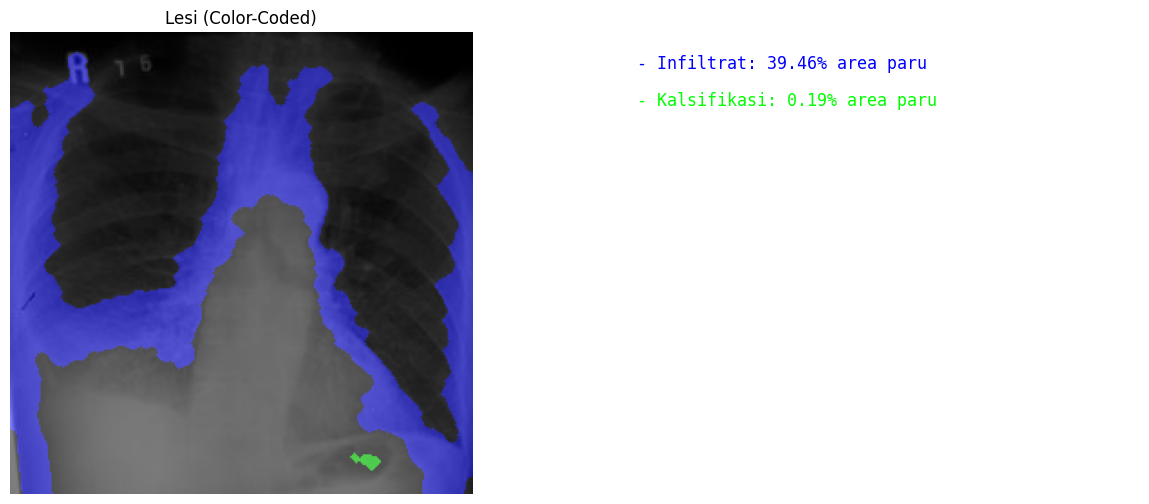

In [ ]:
# --- Tes dengan 1 gambar ---
test_img_path = "img/TB.1536.jpg"
img = imread(test_img_path)

if img.ndim == 3:
    img = rgb2gray(img)
    img = (img * 255).astype(np.uint8)
else:
    img = img.astype(np.uint8)

lung_mask = segment_lung(img)

overlay, lesion_percent = highlight_lesions_detailed(img, lung_mask, verbose=False)

# --- Tampilkan hasil ---
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Overlay
ax[0].imshow(img, cmap="gray")
ax[0].imshow(overlay, alpha=0.5)
ax[0].set_title("Lesi (Color-Coded)")
ax[0].axis("off")

# Legend teks dengan warna
ax[1].axis("off")
y_pos = 0.95
for cls, pct in lesion_percent.items():
    color = np.array(lesion_colors.get(cls, (0, 0, 0))) / 255.0
    ax[1].text(0.05, y_pos, f"- {cls}: {pct:.2f}% area paru",
               fontsize=12, va="top", family="monospace", color=color)
    y_pos -= 0.08

plt.show()